## Running the Fast & Fusiest Mapper (FFM)
This notebook shows how to run the Fast & Fuseiest Mapper (FFM) on a full workload and
architecture.

In [1]:
# Imports
import fastfusion as ff
from IPython.display import SVG, display
import os
ff.set_n_parallel_jobs(16)#os.cpu_count(), print_message=True)

In [2]:
# Initialize the specification and show the workload.
BATCH_SIZE = 4
N_TOKENS = 4096
FUSE = True

spec = ff.Spec.from_yaml(
    # "arches/tpu_v4i_like.yaml",
    "arches/tpu_v4i_like_constrained.yaml",
    # "arches/simple.arch.yaml",
    "workloads/gpt3_6.7B.yaml",
    # "workloads/matmuls8_mixed.workload.yaml",
    jinja_parse_data=dict(
        BATCH_SIZE=BATCH_SIZE,
        N_TOKENS=N_TOKENS,
    )
)

# If fusion is disabled, keep all tensors in main memory.
if not FUSE:
    spec.arch.nodes["MainMemory"].constraints.tensors.keep = "All()"

# display(SVG(spec.workload.render()))

WARNING Loading configuration file from /root/.config/fastfusion/config.yaml


In [ ]:
# Generate the pmappings.

# Set optimization metrics
# spec.mapper.ffm.metrics = ff.mapper.FFM.Metrics.ENERGY
# spec.mapper.ffm.metrics = ff.mapper.FFM.Metrics.LATENCY
spec.mapper.ffm.metrics = ff.mapper.FFM.Metrics.LATENCY | ff.mapper.FFM.Metrics.ENERGY

pmappings = ff.mapper.FFM.make_pmappings(
    spec,
    can_combine_multiple_runs=False,
    cache_dir="cache",
)

# Simanneal before:
# -- number of pmappings per Einsum
# ++ per-Pmapping runtime

# Changes:
# + pmappings per Einsum
# - per-pmapping runtime


________________________________________________________________________________
[Memory] Calling fastfusion.mapper.FFM._interface.main.make_pmappings.<locals>._make_pmappings_cached...
_make_pmappings_cached(spec=Specification(type=None, arch=Arch(type=None, nodes=ArchNodes([Memory(type=None, name='MainMemory', attributes=MemoryAttributes(type=None, global_cycle_period='REQUIRED', n_instances=1, energy_scale=1, area_scale=1, energy=None, area=None, datawidth={'All()': 8}, bandwidth_reads_plus_writes_per_cycle='614e9 / 1.05e9', bandwidth_reads_per_cycle=inf, bandwidth_writes_per_cycle=inf, size='inf'), spatial=[], constraints=ConstraintGroup(type=None, name=None, misc=Misc(type=None, enabled=True), spatial=[], temporal=Temporal(type=None, version='0.5', reuse='All', loop_bounds=[], rmw_first_update=[]), tensors=Tensors(type=None, bypass='~All', keep='~Intermediates()', tile_shape=[], no_refetch_from_a..., einsum_names=None, can_combine_multiple_runs=False)


Generating pmapping templates for compute scalar_unit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum I: 3it [00:00, 18.47it/s]it/s]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]]
Generating pmapping templates for compute scalar_unit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum AV: 0it [00:00, ?it/s],  9.02it/s]
Generating pmapping templates for compute scalar_unit Einsum FFB: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum QK_s

In [4]:
# Output some stats about the generated pmappings.
print(f"Total number of pmappings: {pmappings.total_pmappings()}")
print(f"Number of valid pmappings: {pmappings.valid_pmappings()}")
print(f"Number of Pareto-optimal pmappings: {pmappings.pareto_optimal_pmappings()}")
print(f"Number of evaluated pmappings: {pmappings.evaluated_pmappings()}")

Total number of pmappings: 67999180715.32598
Number of valid pmappings: 161692781.0
Number of Pareto-optimal pmappings: 492519
Number of evaluated pmappings: 392396470


In [5]:
import copy

s = "energy" if spec.mapper.ffm.metrics == ff.mapper.FFM.Metrics.ENERGY else "latency"

if spec.mapper.ffm.metrics == ff.mapper.FFM.Metrics.ENERGY:
    s = "energy"
    acc = lambda x: x[f"Total<SEP>{s}"]
elif spec.mapper.ffm.metrics == ff.mapper.FFM.Metrics.LATENCY:
    s = "latency"
    acc = lambda x: x[f"Total<SEP>{s}"]
elif spec.mapper.ffm.metrics == ff.mapper.FFM.Metrics.LATENCY | ff.mapper.FFM.Metrics.ENERGY:
    s = "EDP"
    acc = lambda x: x[f"Total<SEP>energy"] * x[f"Total<SEP>latency"]

class FilterLambda:
    def __init__(
        self,
        best_edp: float,
        min_latency: float,
        min_energy: float,
    ):
        self.best_edp = best_edp
        self.min_latency = min_latency
        self.min_energy = min_energy
        
    def __call__(self, x):
        a = acc(x) <= self.best_edp
        b = x["Total<SEP>energy"] * self.min_latency <= self.best_edp
        c = x["Total<SEP>latency"] * self.min_energy <= self.best_edp
        return a & b & c

SIMANNEAL = False

if not SIMANNEAL:
    # ff.set_n_parallel_jobs(1, print_message=True)
    
    def filter_lambda(pm):
        return all(len(x.loops) == 0 for x in pm.compatibility.tensors)

    mappings = ff.mapper.FFM.join_pmappings(spec, pmappings.filter(filter_lambda))
    
    min_latency = sum(min(s.mappings.data[f'Total<SEP>latency'].min() for s in sg) for sg in pmappings.einsum2pmappings.values() )
    min_energy = sum(min(s.mappings.data[f'Total<SEP>energy'].min() for s in sg) for sg in pmappings.einsum2pmappings.values() )
    
    print(f"Min latency: {min_latency}")
    print(f"Min energy: {min_energy}")

    f = FilterLambda(
        best_edp=acc(mappings[0]),
        min_latency=min_latency,
        min_energy=min_energy,
    )
    
    print(f"Filtering pmappings with {s} > {acc(mappings[0])}")

    # Join the pmappings to create a full mapping.
    mappings = ff.mapper.FFM.join_pmappings(
        spec,
        pmappings,
        pmapping_row_filter_function=f
    )
else:
    # Join the pmappings to create a full mapping.
    ff.set_n_parallel_jobs(1, print_message=True)
    mappings = ff.mapper.simanneal2.join_pmappings(
        spec,
        pmappings,
    )

# B=4 M=4096 energy GPT3 6.7B: 3.298055658930176
# B=16 M=16384 latency GPT3 6.7B: 6.143656716190474
# B=16 M=16384 energy GPT3 6.7B: no tiled fusion 78.77919305944275 tiled fusion 76.15561453482806 

# B=4 M=4096 GPT3 6.7B constrained EDP: no tiled fusion 0.8114784135864749 tiled fusion 0.79312786266
# Totals:
# 	latency: 0.24017383619047622
# 	energy: 3.3023075087810563


Einsum I has 2 pmappings with 2 compatibilities
Einsum V has 75 pmappings with 9 compatibilities
Einsum K has 75 pmappings with 9 compatibilities
Einsum Q has 75 pmappings with 9 compatibilities
Einsum QK has 75 pmappings with 4 compatibilities
Einsum QK_softmax has 1 pmappings with 1 compatibilities
Einsum AV has 74 pmappings with 4 compatibilities
Einsum Z has 75 pmappings with 9 compatibilities
Einsum FFA has 20 pmappings with 2 compatibilities
Einsum FFB has 1 pmappings with 1 compatibilities


Compressing pmappings: 100%|██████████| 10/10 [00:00<00:00, 300.11it/s]


Not tracking GlobalBuffer because it is never reserved for multiple pmappings.
Not tracking LocalBuffer because it is never reserved for multiple pmappings.
Not tracking MainMemory because it is never reserved for multiple pmappings.
Not tracking Register because it is never reserved for multiple pmappings.


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 15709.00it/s]


Min latency: 0.24017383619047616
Min energy: 3.291539254018048
Filtering pmappings with EDP > 0.8114784135864749
Einsum I has 508 pmappings with 9 compatibilities
Einsum V has 29576 pmappings with 397 compatibilities
Einsum K has 29576 pmappings with 397 compatibilities
Einsum Q has 29576 pmappings with 397 compatibilities
Einsum QK has 143006 pmappings with 764 compatibilities
Einsum QK_softmax has 52081 pmappings with 143 compatibilities
Einsum AV has 142964 pmappings with 764 compatibilities
Einsum Z has 29599 pmappings with 397 compatibilities
Einsum FFA has 14326 pmappings with 180 compatibilities
Einsum FFB has 21307 pmappings with 79 compatibilities


Compressing pmappings: 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


Filtered 985038 -> 962546 (97.72% kept) pmappings
Not tracking LocalBuffer because it is never reserved for multiple pmappings.
Not tracking Register because it is never reserved for multiple pmappings.
Not tracking MainMemory because its size inf is enough for the sum of all reservations (59592671232)


Grouping pmappings: 100%|██████████| 984/984 [00:15<00:00, 64.88it/s]


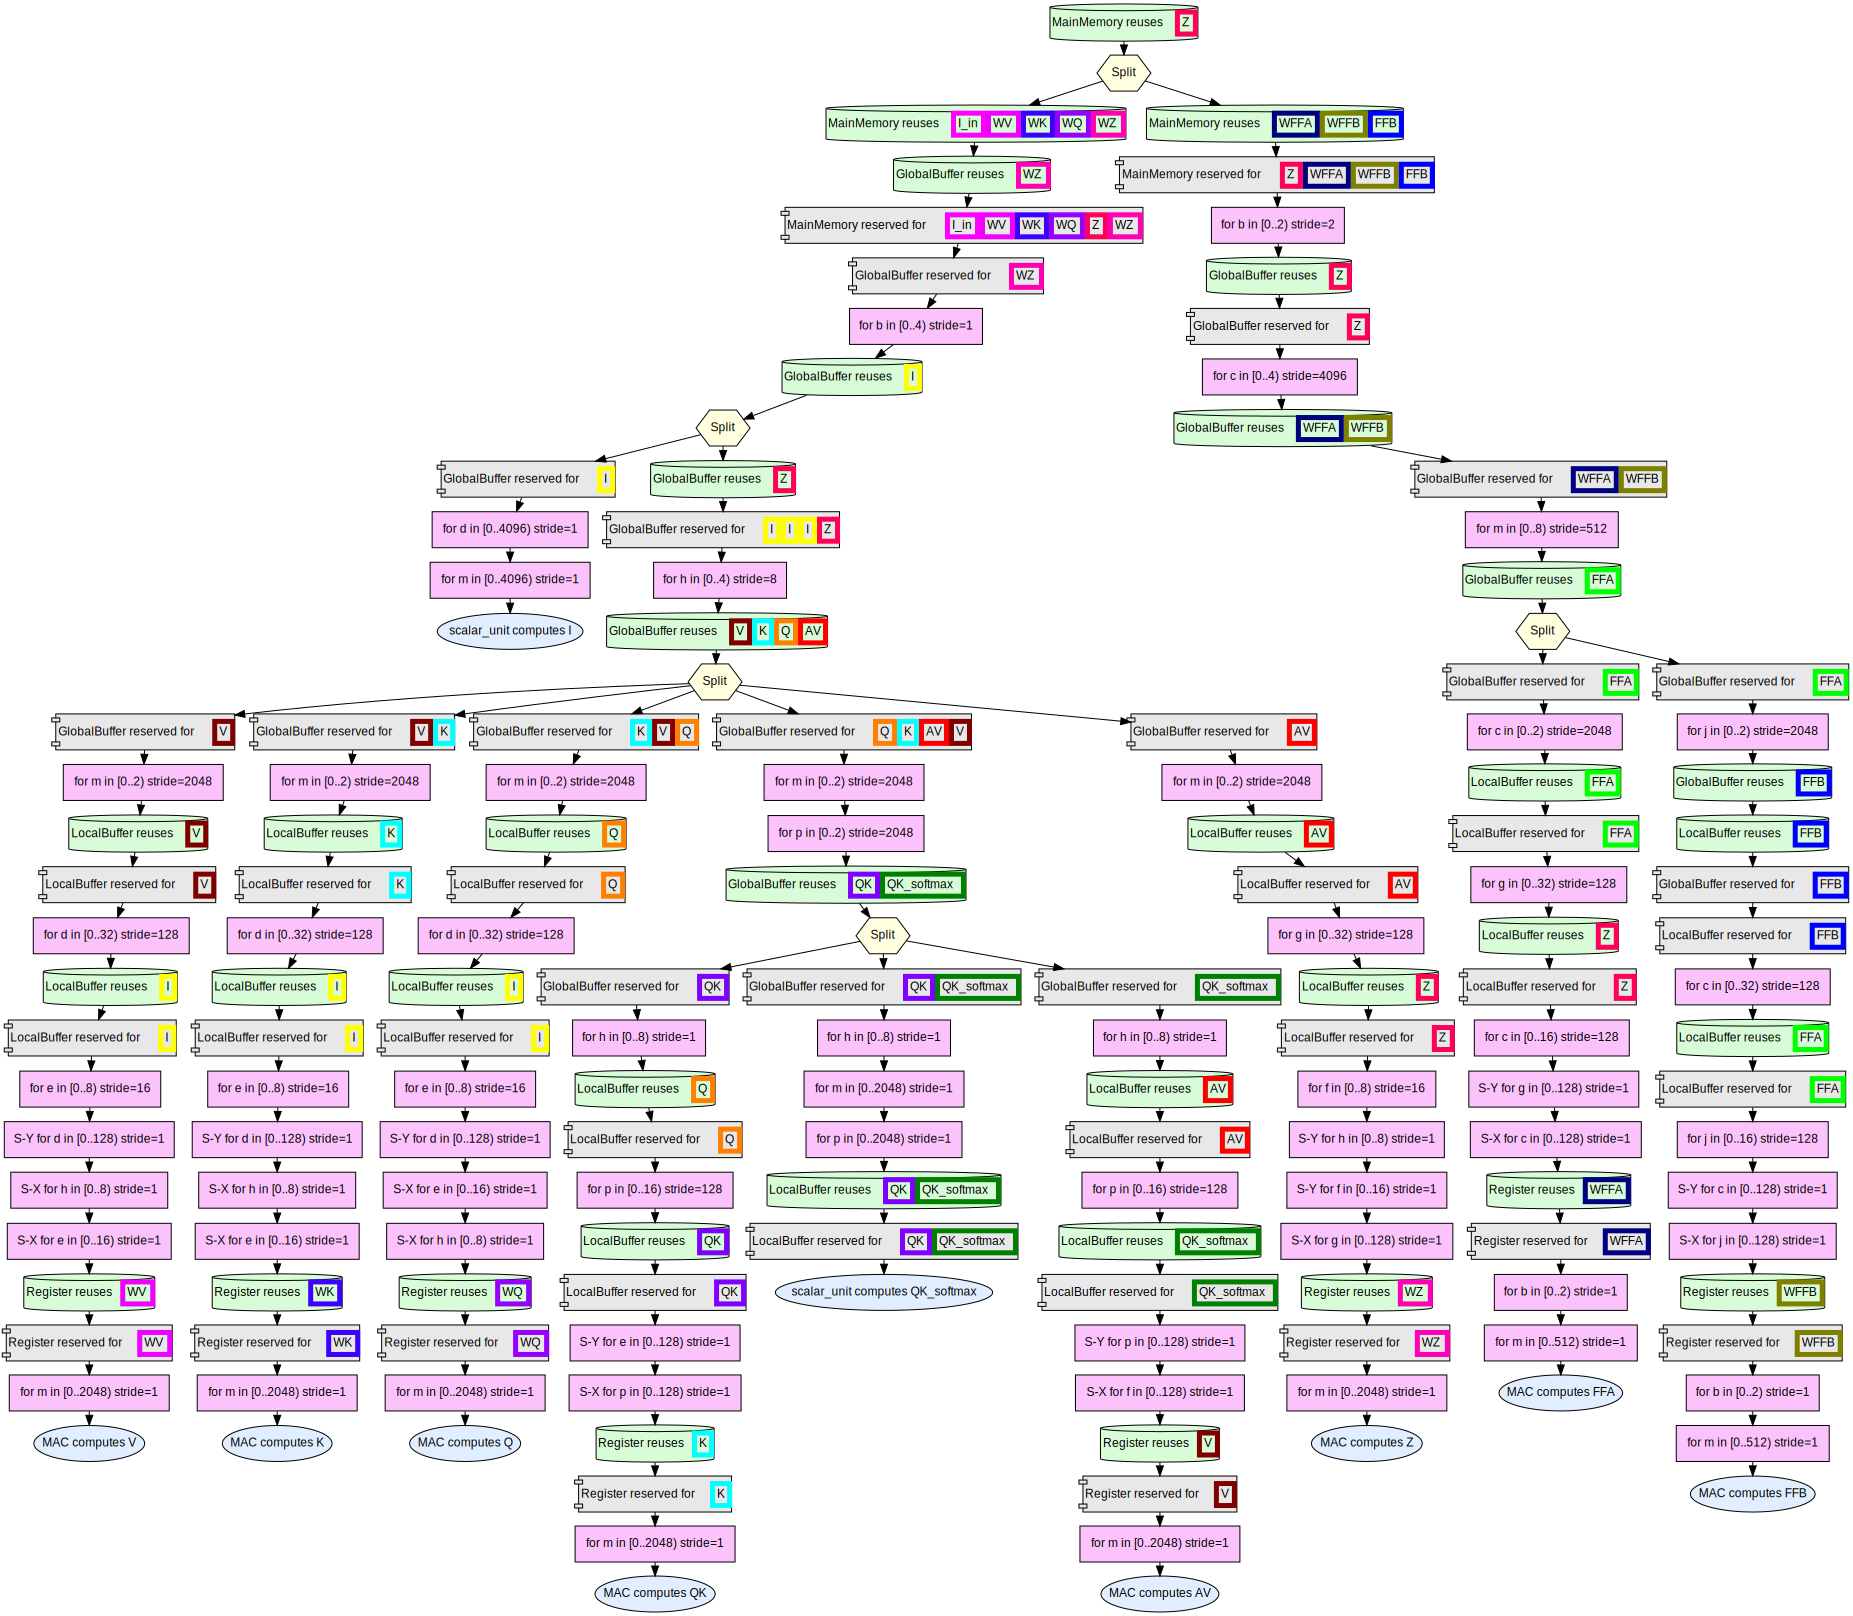

Totals:
	latency: 0.24017383619047622
	energy: 3.3023075087810563
	mapping: <fastfusion.mapper.FFM._interface.main.MappingFromRow object at 0x7fec4b4b1d30>


KeyError: 'EDP'

In [6]:
# The joined pmappings object contains a DataFrame of all Pareto-optimal pmappings for
# the given optimization metrics. Since we're only interested in one metric, this should
# have exaclty one row, but we'll grab index 0 to be sure.
mappings = mappings[0]

# Show the mapping.
display(SVG(mappings.render()))

# All units are SI units-- seconds, joules, meters, etc.
print(f"Totals:")
for k, v in mappings.access("Total").to_dict().items():
    print(f"\t{k}: {v}")

per_compute = mappings.access("Total").per_compute().to_dict()[s]
print(f'Per-compute {s}: {per_compute}')

print(f'Contributors to {s}:')
for k, v in mappings.access(s).to_dict().items():
    print(f"\t{k}: {v}")

In [ ]:
# Print the other stats
for k, v in mappings.to_dict().items():
    print(f"{k}: {v}")